In [1]:
import sys

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

sys.path.append("/home/aseliverstov/projects/brain_signals/experiments/src")
from src.dataset import EEG
from src.features import calculate_summary_features
from src.augmentations import augment_timeseries

2025-02-02 00:54:08.254849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 00:54:08.259639: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 00:54:08.270182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738446848.286791  139369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738446848.291195  139369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 00:54:08.312188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/dataset")
intencities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_channels = 31

mona_dataset = EEG(data_dir=data_dir, intencities=intencities, n_channels=n_channels, image_name="Figs for spectra")
cube_dataset = EEG(data_dir=data_dir, intencities=intencities, n_channels=n_channels, image_name="Cubes for spectra")

mona_dataset.load_to_dataframe(users=[1], signals=["delta", "theta", "alpha", "beta", "gamma"])
cube_dataset.load_to_dataframe(users=[1], signals=["delta", "theta", "alpha", "beta", "gamma"])

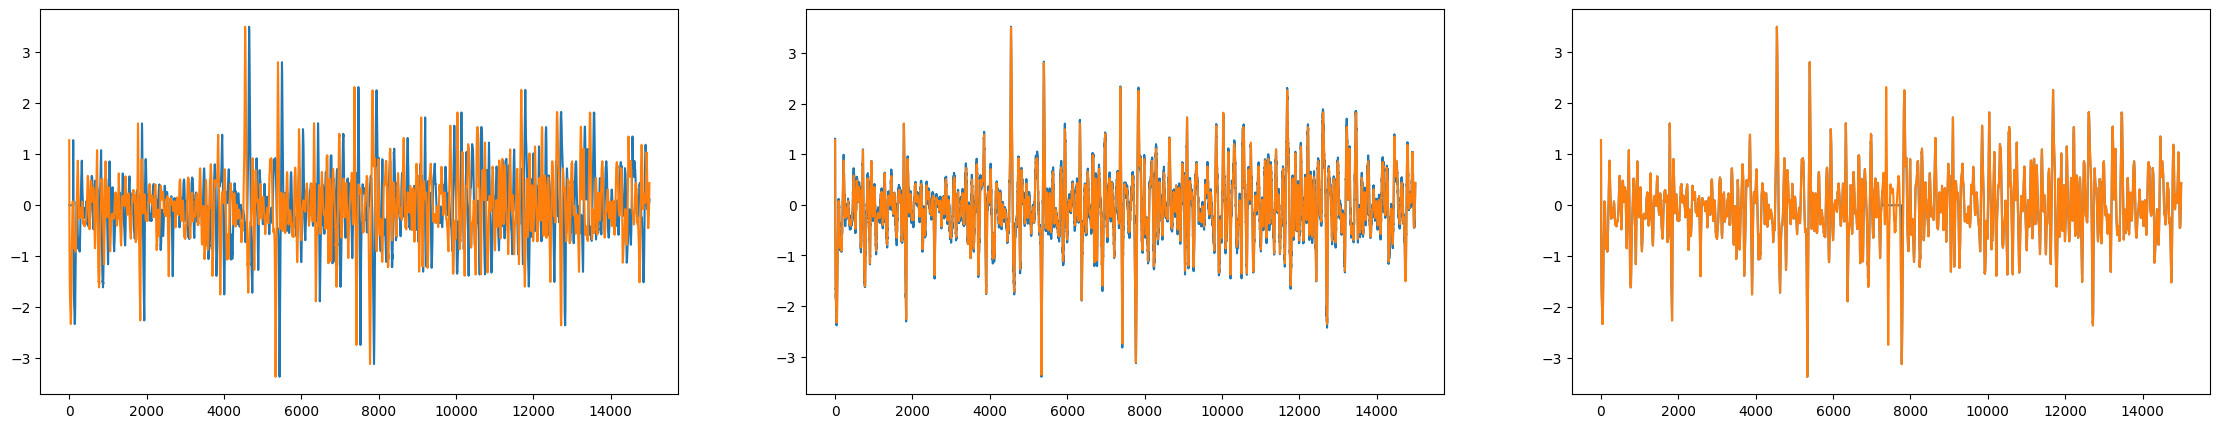

In [3]:
import matplotlib.pyplot as plt

X_train, y_train = mona_dataset.X, mona_dataset.y
X_test, y_test = cube_dataset.X, cube_dataset.y

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ts_to_plot = augment_timeseries(
    X_train[0:1], y_train[0:1],
    num_shift=1, shift_params={'n_timestamps': 500, 'seed': 42},
    num_noise=1, noise_params={'noise_intensity': 0.05, 'seed': 42},
    num_mask=1, mask_params={'mask_length': 500, 'seed': 42}
)[0]

fig, ax = plt.subplots(1, 3, figsize=(28, 5))

for i in range(1, 4):
    ax[i - 1].plot(ts_to_plot[i])
    ax[i - 1].plot(ts_to_plot[0])


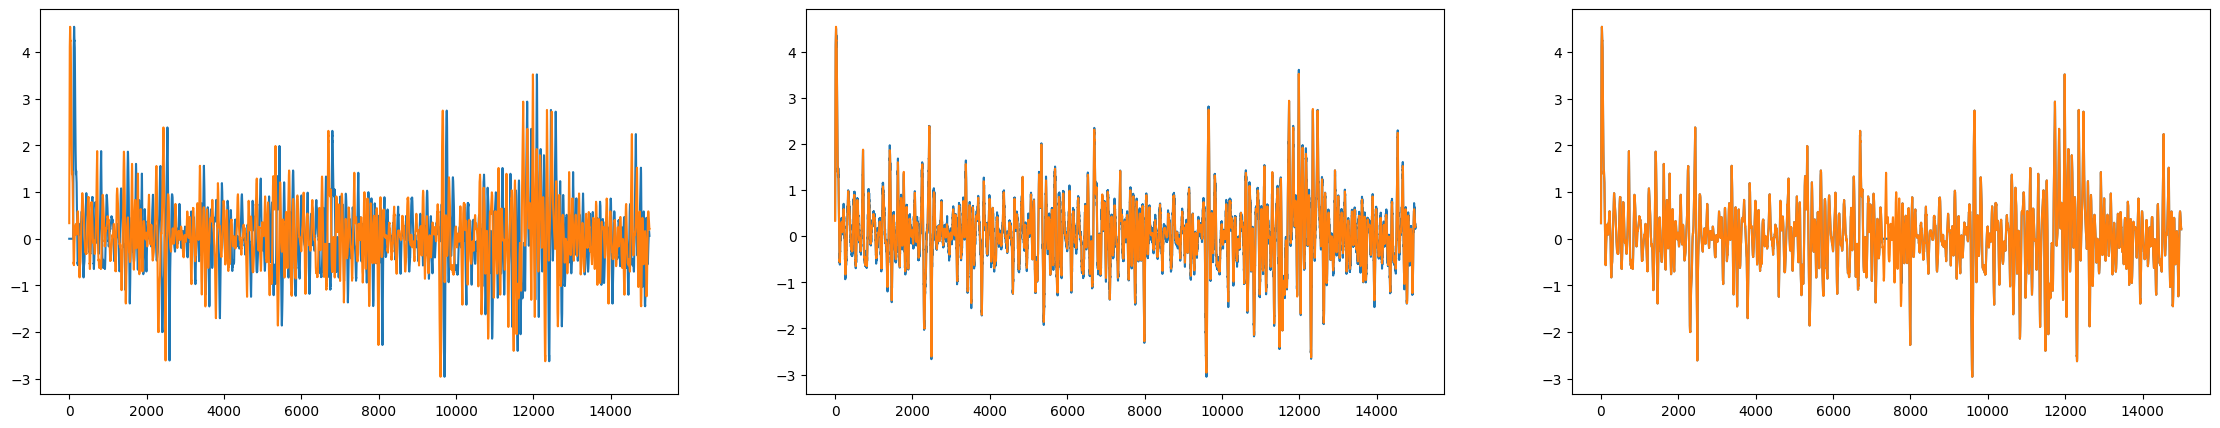

In [4]:
ts_to_plot = augment_timeseries(
    X_test[0:1], y_test[0:1],
    num_shift=1, shift_params={'n_timestamps': 500, 'seed': 42},
    num_noise=1, noise_params={'noise_intensity': 0.05, 'seed': 42},
    num_mask=1, mask_params={'mask_length': 500, 'seed': 42}
)[0]

fig, ax = plt.subplots(1, 3, figsize=(28, 5))

for i in range(1, 4):
    ax[i - 1].plot(ts_to_plot[i])
    ax[i - 1].plot(ts_to_plot[0])

# Model

In [13]:
X_train, y_train = mona_dataset.X, mona_dataset.y
X_test, y_test = cube_dataset.X, cube_dataset.y

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, y_train = augment_timeseries(
    X_train, y_train,
    num_shift=500, shift_params={'n_timestamps': 500, 'seed': 42},
    num_noise=1200, noise_params={'noise_intensity': 0.05, 'seed': 42},
    num_mask=500, mask_params={'mask_length': 500, 'seed': 42}
)

X_train = calculate_summary_features(X_train, n_windows=5)
X_test = calculate_summary_features(X_test, n_windows=5)

X_train.shape

(3750, 30)

In [15]:
model = Sequential()
model.add(Dense(16, input_shape= (X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=mse,
)
model.summary()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=32, verbose=1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913 (3.57 KB)

 Trainable params: 913 (3.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3793 - val_loss: 1.0779
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9336 - val_loss: 0.8332
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1809 - val_loss: 0.6467
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2060 - val_loss: 0.5290
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0207 - val_loss: 0.4489
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2522 - val_loss: 0.3850
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8101 - val_loss: 0.3392
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9425 - val_loss: 0.3002
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8519 - val_loss: 0.2713
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9644 - val_loss: 0.2488
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8197 - val_loss: 0.2265
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step